In [3]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
if not dir1 in sys.path: sys.path.append(dir1)
from utils.environment import setup_data_vars
setup_data_vars()

In [4]:
from torch.utils.data import Dataset, DataLoader
import random
import math
import numpy as np
import cv2
import torch

class UniverSegDataSet(Dataset):
    def __init__(self, support_size, training=True):

        self.medsam_gts = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts')
        self.medsam_imgs = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')

        self.support_size = support_size

        self.training = training
        self.anatomies = dict([(f, dict()) for f in os.listdir(self.medsam_gts) if f != 'TotalBinary'])

        min_samples = float('inf')

        for anatomy in self.anatomies.keys():
            for axis in [f for f in os.listdir(os.path.join(self.medsam_gts, anatomy)) if 'axis' in f]:
                subdir = os.path.join(anatomy, axis)

                samples = [f for f in os.listdir(os.path.join(self.medsam_gts, subdir)) if f.endswith('.npy')]
                random.shuffle(samples)

                if len(samples) < min_samples:
                    min_samples = len(samples)

                self.anatomies[anatomy][axis] = samples

        self.anatomy_keys = sorted(list(self.anatomies.keys()))
        self.list_of_axis = sorted(list(self.anatomies[self.anatomy_keys[0]].keys()))

        self.setup_sampler()

        self.training_length = min_samples * len(self.anatomy_keys) * len(self.list_of_axis)

    def set_training(self):
        self.training = True
        self.setup_sampler()

    def set_validation(self):
        self.training = False
        self.setup_sampler()

    def __len__(self):
        return self.training_length
    
    def setup_sampler(self):
        if self.training:
            self._sample_to_consider = lambda idx: (idx // (len(self.list_of_axis) * len(self.anatomy_keys)))
        else:
            self._sample_to_consider = lambda idx: -(idx // (len(self.list_of_axis) * len(self.anatomy_keys))) - 1

    def _read_image_and_gt(self, img_id, img_slice, anatomy, axis):
        img = np.load(os.path.join(self.medsam_imgs, f'axis{axis}', f'CT_zzAMLART_{img_id:03d}-{img_slice:03d}.npy'))
        gt = np.load(os.path.join(self.medsam_gts, anatomy, f'axis{axis}', f'CT_{anatomy}_zzAMLART_{img_id:03d}-{img_slice:03d}.npy'))
        return img, gt

    def _anatomy_to_consider(self, idx):
        return self.anatomy_keys[(idx // len(self.list_of_axis)) % len(self.anatomy_keys)]
    
    def _axis_to_consider(self, idx):
        return self.list_of_axis[idx % len(self.list_of_axis)]
    
    def __getitem__(self, idx):
        anatomy_to_consider = self._anatomy_to_consider(idx)
        axis_to_consider = self._axis_to_consider(idx)
        sample_to_consider = self._sample_to_consider(idx)

        ith_example = self.anatomies[anatomy_to_consider][axis_to_consider][sample_to_consider]

        get_id_from_img = lambda img_name: int(img_name.split('_')[3].split('-')[0])
        get_slice_from_img = lambda img_name: int(img_name.split('_')[3].split('-')[1].split('.')[0])

        ith_id = get_id_from_img(ith_example)
        ith_slice = get_slice_from_img(ith_example)

        # get a support set that doesn't contain the same id as the ith example
        support_set = random.sample([f for f in self.anatomies[anatomy_to_consider][axis_to_consider] if get_id_from_img(f) != ith_id], self.support_size)

        # read in the images and gts for the ith example and the support set and resize them appropriately
        ith_img, ith_gt = self._read_image_and_gt(ith_id, ith_slice, anatomy_to_consider, int(axis_to_consider[-1]))

        support_imgs = []
        support_gts = []

        for support_example in support_set:
            support_img, support_gt = self._read_image_and_gt(get_id_from_img(support_example), get_slice_from_img(support_example), anatomy_to_consider, int(axis_to_consider[-1]))

            support_imgs.append(support_img)
            support_gts.append(support_gt)

        # resize the images and gts to 128x128 we need for universeg

        ith_img = cv2.resize(ith_img, (128, 128), interpolation=cv2.INTER_LINEAR)
        ith_gt = cv2.resize(ith_gt, (128, 128), interpolation=cv2.INTER_NEAREST)

        support_imgs = [cv2.resize(support_img, (128, 128), interpolation=cv2.INTER_LINEAR) for support_img in support_imgs]
        support_gts = [cv2.resize(support_gt, (128, 128), interpolation=cv2.INTER_NEAREST) for support_gt in support_gts]

        # convert to torch tensors

        ith_img = torch.from_numpy(ith_img).float().unsqueeze(0)
        ith_gt = torch.from_numpy(ith_gt).float().unsqueeze(0)

        support_imgs = [torch.from_numpy(support_img).float().unsqueeze(0) for support_img in support_imgs]
        support_gts = [torch.from_numpy(support_gt).float().unsqueeze(0) for support_gt in support_gts]

        # stack the support images and gts
        support_imgs = torch.stack(support_imgs) # (S x 128 x 128)
        support_gts = torch.stack(support_gts) # (S x 128 x 128)

        assert support_imgs.shape == (self.support_size, 1, 128, 128), support_imgs.shape
        assert support_gts.shape == (self.support_size, 1, 128, 128), support_gts.shape
        assert ith_img.shape == (1, 128, 128), ith_img.shape
        assert ith_gt.shape == (1, 128, 128), ith_gt.shape

        return {
            'query_name': ith_example,
            'query_anatomy_axis': f'{anatomy_to_consider}_{axis_to_consider}', 
            'query': ith_img,
            'query_gt': ith_gt,
            'support_name': support_set,
            'support_imgs': support_imgs,
            'support_gts': support_gts
        }

In [5]:
import SimpleITK as sitk
from universeg import universeg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

# Run the inference
model = universeg(pretrained=True)
model = model.to(device)
checkpoint = torch.load('results_finetuned/finetuning/model_checkpoint_best.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [15]:
from tqdm import tqdm
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd

model.eval()

per_support_size_apl = {}
per_support_size_dice = {}
per_support_size_haussdorf = {}
per_support_size_rvd = {}
per_support_size_surface_dsc = {}

iterations = 100
support_size_min = 1
support_size_max = 150

support_size = list(range(1, 10)) + list(range(10, 50, 5)) + list(range(50, 151, 10))

progress_bar = tqdm(support_size)
for support_size in progress_bar:

    progress_bar.set_description(f'Support size: {support_size}')

    # set up a new dataset for each support size to ensure that support samples are
    # different
    dataset = UniverSegDataSet(support_size=support_size, training=True)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    data_iterator = iter(dataloader)

    per_iter_apl = []
    per_iter_dice = []
    per_iter_haussdorf = []
    per_iter_rvd = []
    per_iter_surface_dsc = []

    for i in range(iterations):
        progress_bar.set_description(f'Support size: {support_size}, Iteration: {i}/{iterations}, Dice: {np.mean(per_iter_dice):.4f}, APL: {np.mean(per_iter_apl):.4f}, Hausdorff: {np.mean(per_iter_haussdorf):.4f}, RVD: {np.mean(per_iter_rvd):.4f}, Surface DSC: {np.mean(per_iter_surface_dsc):.4f}')

        sample = next(data_iterator)

        names = sample['query_name'] # [0]
        image = sample['query'].to(device)
        label = sample['query_gt']
        support_images = sample['support_imgs'].to(device)
        support_labels = sample['support_gts'].to(device)

        image = image.to(device)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)

        with torch.no_grad():
            prediction_logits = model(image, support_images, support_labels)
        
        prediction_soft = torch.sigmoid(prediction_logits)
        prediction_hard = (prediction_soft > 0.5).float()

        prediction = sitk.GetImageFromArray(prediction_hard.cpu().detach().numpy()[0].astype(np.uint8))
        label_sitk = sitk.GetImageFromArray(label.numpy()[0].astype(np.uint8))

        # prediction = sitk.Cast(prediction, sitk.sitkUInt8)
        label_sitk = sitk.Cast(label_sitk, sitk.sitkUInt8)

        overlap_measures_filter.Execute(prediction, label_sitk)

        dice = overlap_measures_filter.GetDiceCoefficient()
        hd = compute_metric_hd(label_sitk, prediction)
        volume_similarity = overlap_measures_filter.GetVolumeSimilarity()
        surface_dsc = compute_surface_dsc(label_sitk, prediction)
        apl = compute_metric_total_apl(label_sitk, prediction)

        if not np.isnan(dice): per_iter_dice.append(dice)
        if not np.isnan(apl): per_iter_apl.append(apl)
        if not np.isnan(hd): per_iter_haussdorf.append(hd)
        if not np.isnan(volume_similarity): per_iter_rvd.append(volume_similarity)
        if not np.isnan(surface_dsc): per_iter_surface_dsc.append(surface_dsc)
    
    per_support_size_dice[support_size] = per_iter_dice
    per_support_size_apl[support_size] = per_iter_apl
    per_support_size_haussdorf[support_size] = per_iter_haussdorf
    per_support_size_rvd[support_size] = per_iter_rvd
    per_support_size_surface_dsc[support_size] = per_iter_surface_dsc

Support size: 1:   0%|          | 0/28 [00:00<?, ?it/s]

Support size: 40:  54%|█████▎    | 15/28 [00:09<00:08,  1.59it/s]                                                                                                   


KeyboardInterrupt: 

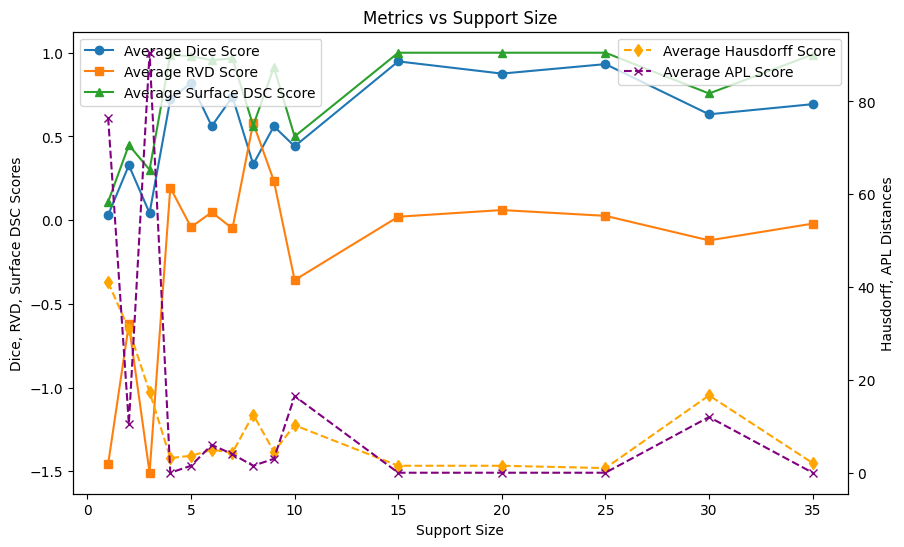

In [20]:
import matplotlib.pyplot as plt

# Calculate averages
def calculate_averages(data):
    return {key: sum(values) / len(values) for key, values in data.items()}

average_dice = calculate_averages(per_support_size_dice)
average_rvd = calculate_averages(per_support_size_rvd)
average_surface_dsc = calculate_averages(per_support_size_surface_dsc)
average_haussdorf = calculate_averages(per_support_size_haussdorf)
average_apl = calculate_averages(per_support_size_apl)

support_sizes = list(average_dice.keys())
average_dice_scores = list(average_dice.values())
average_rvd_scores = list(average_rvd.values())
average_surface_dsc_scores = list(average_surface_dsc.values())
average_haussdorf_scores = list(average_haussdorf.values())
average_apl_scores = list(average_apl.values())

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting dice, rvd, and surface dsc on the left y-axis
ax1.plot(support_sizes, average_dice_scores, 'o-', label='Average Dice Score')
ax1.plot(support_sizes, average_rvd_scores, 's-', label='Average RVD Score')
ax1.plot(support_sizes, average_surface_dsc_scores, '^-', label='Average Surface DSC Score')

ax1.set_xlabel('Support Size')
ax1.set_ylabel('Dice, RVD, Surface DSC Scores')
ax1.legend(loc='upper left')
ax1.set_title('Metrics vs Support Size')

# Create a second y-axis
ax2 = ax1.twinx()

# Plotting hausdorff and apl on the right y-axis
ax2.plot(support_sizes, average_haussdorf_scores, 'd--', color='orange', label='Average Hausdorff Score')
ax2.plot(support_sizes, average_apl_scores, 'x--', color='purple', label='Average APL Score')

ax2.set_ylabel('Hausdorff, APL Distances')
ax2.legend()

# Display the plot
plt.show()